In [1]:
%load_ext autoreload
%autoreload 2

# Readme
Change dataset, crop_id, obj_id only

# 1. Crop images

In [2]:
# load sam
from src.model.sam import CustomSamAutomaticMaskGenerator, load_sam
from segment_anything.modeling.sam import Sam
model_type = "vit_h"
checkpoint_dir =  "datasets/bop23_challenge/pretrained/segment-anything"
sam_model = load_sam(model_type, checkpoint_dir)
custom_sam_model = CustomSamAutomaticMaskGenerator(sam=sam_model) #, crop_overlap_ratio = 750 / 1500) # , box_nms_thresh = 0.6 )

In [3]:
def move_to_device(segmentor_model, device="cuda"):
    # if there is predictor in the model, move it to device
    if hasattr(segmentor_model, "predictor"):
        segmentor_model.predictor.model = (
            segmentor_model.predictor.model.to(device)
        )
    else:
        segmentor_model.model.setup_model(device=device, verbose=True)
move_to_device(custom_sam_model)

In [4]:
from PIL import Image
import torch
import numpy as np
from src.model.utils import Detections

dataset = "icbin"
rgb_path = "cnos_analysis/crop_proposals/000001.png" # f"datasets/bop23_challenge/datasets/{dataset}/test/000048/rgb/000001.png"
rgb = Image.open(rgb_path).convert("RGB")
detections = custom_sam_model.generate_masks(np.array(rgb))

In [5]:
detections["boxes"]

tensor([[562, 413, 639, 478],
        [216, 191, 372, 314],
        [277, 115, 356, 189],
        [ 68, 314, 288, 477],
        [182, 198, 528, 425],
        [445,   0, 542,  58],
        [351, 119, 460, 216],
        [295, 247, 417, 342],
        [127, 344, 231, 419],
        [215, 188, 291, 287],
        [293, 191, 371, 263],
        [337, 406, 477, 478],
        [162, 169, 231, 253],
        [209, 117, 275, 178],
        [479, 335, 598, 410],
        [231, 170, 303, 209],
        [329,  36, 383, 140],
        [184, 171, 302, 287],
        [358, 188, 465, 303],
        [168,  48, 346, 131],
        [389,   3, 445,  28],
        [351, 119, 410, 192],
        [397, 418, 458, 467],
        [553, 144, 639, 178],
        [316, 309, 372, 342],
        [549,   0, 639,  25],
        [526, 274, 639, 358],
        [364, 439, 416, 478],
        [218, 232, 276, 269],
        [216, 217, 351, 314],
        [167,  23, 183,  46],
        [  0, 205, 214, 477],
        [477,  50, 558,  68],
        [ 

In [6]:
def extract_object_by_mask(image, mask, width: int = 512):
    mask = Image.fromarray(mask)
    masked_image = Image.composite(
        image, Image.new("RGB", image.size, (0, 0, 0)), mask)
    cropped_image = masked_image.crop(masked_image.getbbox())
    # new_height = width * cropped_image.height // cropped_image.width
    return cropped_image

masked_images = []
for mask in detections["masks"].cpu():
    binary_mask = np.array(mask) * 255
    binary_mask = binary_mask.astype(np.uint8)
    masked_image = extract_object_by_mask(rgb, binary_mask)
    masked_images.append(masked_image)

In [7]:
# # Visualize proposals
# import matplotlib.pyplot as plt
# from math import ceil
# def plot_images(images, rows, cols):
#     fig, axes = plt.subplots(rows, cols, figsize=(20, 30))
#     for i, ax in enumerate(axes.flat):
#         if i >= len(images):
#             break
#         ax.imshow(images[i])
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

# # Define the number of rows and columns in the grid
# rows = ceil(len(masked_images) / 6)
# cols = 6
# # Plot the masked_images array in a grid
# plot_images(masked_images, rows, cols) 

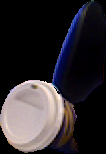

In [8]:
import os

# Choose crop 4 it is in object id 12
crop_idx = 131 # 125, 102 for background; 131 for foreground
obj_id = 1
crop1 = {
    "crop" : masked_images[crop_idx], # it is saved as Image so crop1["crop"] to visualize it
    "masks" : detections["masks"][crop_idx],
    "boxes" : detections["boxes"][crop_idx]
}

# Save image
if not os.path.exists(f"foundpose_analysis/{dataset}"):
    os.makedirs(f"foundpose_analysis/{dataset}")
crop1["crop"].save(f"foundpose_analysis/{dataset}/crop1.png")
crop1["crop"]

# 2. Templates

## 2.1 Create templates of object

In [9]:
# load config file
import hydra
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose

# Initialize Hydra and compose the configuration
initialize(config_path="configs")
cfg = compose(config_name="run_inference")
OmegaConf.set_struct(cfg, False)

/tmp/ipykernel_2556231/531409554.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="configs")


In [10]:
import os
import glob

default_ref_dataloader_config = cfg.data.reference_dataloader
ref_dataloader_config = default_ref_dataloader_config.copy()
ref_dataloader_config._target_ = "src.dataloader.bop_pbr.BOPTemplatePBR"
ref_dataloader_config.root_dir = f"datasets/bop23_challenge/datasets/{dataset}"
ref_dataloader_config.template_dir = " "

level_template = 1 # Level 0 :42 templates, level 1, 162 templates
ref_dataloader_config.level_templates = level_template 
ref_dataloader_config.split = "train_pbr" # train_pbr

ply_files = glob.glob(f"datasets/bop23_challenge/datasets/{dataset}/models/models/*.ply")
obj_ids = sorted([int(os.path.basename(obj_id)[8:10]) for obj_id in ply_files])
ref_dataloader_config.obj_ids = obj_ids

out_folder = f"foundpose_analysis/{dataset}/templates"
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
ref_dataloader_config.out_dir = out_folder
ref_dataloader_config.templates_output_folder = f"{out_folder}/level_template_{level_template}"

In [11]:
import os
os.environ['HYDRA_FULL_ERROR'] = '1'

In [12]:
# # Error : must delete all metadata.csv 
# # If using test it can happen that the object id doesnt appear in the test folder- so can get empty list - just use try except la ok
# from hydra.utils import instantiate
# ref_dataset = instantiate(ref_dataloader_config) # src.dataloader.bop.BOPTemplatePBR
# ref_dataset.load_processed_metaData(reset_metaData=True)

In [13]:
# from torchvision.utils import save_image
# import pandas as pd

# templates = pd.read_csv(f"{out_folder}/{ref_dataloader_config.split}_processed_metaData.csv")

# # Save templates as images
# for ob_id in range(len(obj_ids)): 
#     obj_id_path = os.path.join(f"{out_folder}/{ref_dataloader_config.split}_images_templates", f'obj_{(ob_id+1):06d}') # The transformed templates - check line 244, 245 in bop_pbr.py
#     original_obj_id_path = os.path.join(f"{out_folder}/{ref_dataloader_config.split}_images_templates", f'obj_{(ob_id+1):06d}_original')
    
#     if not os.path.exists(obj_id_path):
#         os.makedirs(obj_id_path)
#     if not os.path.exists(original_obj_id_path):
#         os.makedirs(original_obj_id_path)

#     try:  
#         for i, img in enumerate(ref_dataset[ob_id]["templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
#             save_image(img, os.path.join(obj_id_path, f'{i:06d}.png'))
#         for i, img in enumerate(ref_dataset[ob_id]["original_templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
#             save_image(img, os.path.join(original_obj_id_path, f'{i:06d}.png'))
#     except Exception as e:
#         print(f"An error occurred: {e}")

## 2.2. Templates features extraction

In [14]:
import glob
import os

obj_id_2 = 2
real_data_type = "test" # test

# Load original templates when before putting through dinov2 we also apply transfomation.
real_template_path_1 = f"{out_folder}/{real_data_type}_images_templates/obj_{obj_id:06d}_original" 
real_template_path_2 = f"{out_folder}/{real_data_type}_images_templates/obj_{obj_id_2:06d}_original" 
real_template_files_1 = sorted(glob.glob(os.path.join(real_template_path_1, "*.png")), key=os.path.getmtime)
real_template_files_2 = sorted(glob.glob(os.path.join(real_template_path_2, "*.png")), key=os.path.getmtime)
real_template_files = real_template_files_1 + real_template_files_2
real_num_templates = len(real_template_files)
real_num_templates

324

In [15]:
import glob
import os

obj_id_2 = 2
syn_data_type = "train_pbr" # test

# Load original templates when before putting through dinov2 we also apply transformation.
syn_template_path_1 = f"{out_folder}/{syn_data_type}_images_templates/obj_{obj_id:06d}_original" 
syn_template_path_2 = f"{out_folder}/{syn_data_type}_images_templates/obj_{obj_id_2:06d}_original" 
syn_template_files_1 = sorted(glob.glob(os.path.join(syn_template_path_1, "*.png")), key=os.path.getmtime)
syn_template_files_2 = sorted(glob.glob(os.path.join(syn_template_path_2, "*.png")), key=os.path.getmtime)
syn_template_files = syn_template_files_1 + syn_template_files_2
syn_num_templates = len(syn_template_files)
syn_num_templates

324

In [16]:
import glob
import os

obj_id_2 = 2

# Load original templates when before putting through dinov2 we also apply transformation.
pyrender_template_path_1 = f"datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_{obj_id:06d}" 
pyrender_template_path_2 = f"datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_{obj_id_2:06d}" 
pyrender_template_files_1 = sorted(glob.glob(os.path.join(pyrender_template_path_1, "*.png")), key=os.path.getmtime)
pyrender_template_files_2 = sorted(glob.glob(os.path.join(pyrender_template_path_2, "*.png")), key=os.path.getmtime)
pyrender_template_files = pyrender_template_files_1 + pyrender_template_files_2
pyrender_num_templates = len(pyrender_template_files)
pyrender_num_templates

1284

In [17]:
from PIL import Image
import numpy as np
# [50:450, 150:500, :3] only for pyrender template not for BlenderProc templates
real_templates = [np.array(Image.open(template_file).convert("RGB"))[:,:,:3] for template_file in real_template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity
syn_templates = [np.array(Image.open(template_file).convert("RGB"))[:,:,:3] for template_file in syn_template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity
pyrender_templates = [np.array(Image.open(template_file).convert("RGB"))[50:450, 150:500, :3] for template_file in pyrender_template_files]

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_vitl14.patch_size = 14
if torch.cuda.is_available():
    dinov2_vitl14 = torch.nn.DataParallel(dinov2_vitl14).to(device)  # Use DataParallel for multiple GPUs

Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main
/home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


normalized_templates shape torch.Size([3, 224, 224])
scaled_padded_templates.shape 324 torch.Size([3, 224, 224])


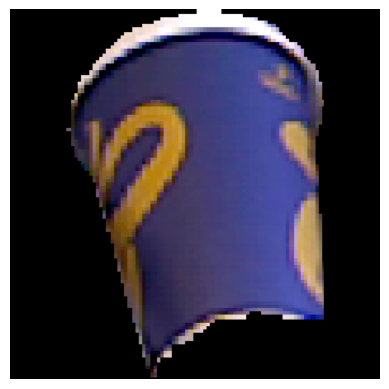

normalized_templates shape torch.Size([3, 224, 224])
scaled_padded_templates.shape 324 torch.Size([3, 224, 224])


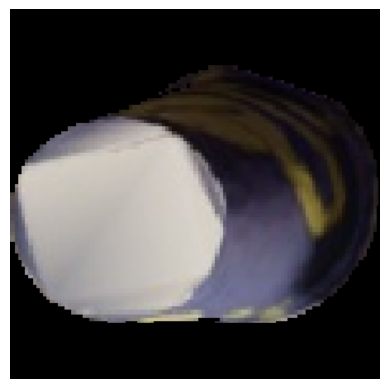

normalized_templates shape torch.Size([3, 400, 350])
scaled_padded_templates.shape 1284 torch.Size([3, 224, 224])


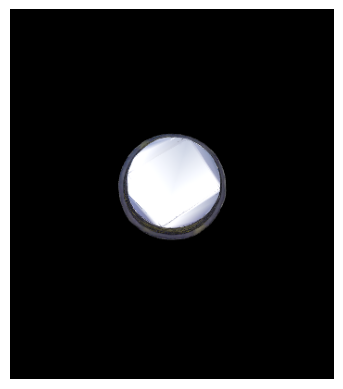

In [19]:
from src.model.custom_cnos import cnos_templates_feature_extraction

real_ref_features = cnos_templates_feature_extraction(
    templates = real_templates, num_templates = real_num_templates, dino_model = dinov2_vitl14, device = device
    )
syn_ref_features = cnos_templates_feature_extraction(
    templates = syn_templates, num_templates = syn_num_templates, dino_model = dinov2_vitl14, device = device
    )
pyrender_ref_features = cnos_templates_feature_extraction(
    templates = pyrender_templates, num_templates = pyrender_num_templates, dino_model = dinov2_vitl14, device = device
    )

In [20]:
pyrender_ref_features.shape

torch.Size([1284, 1024])

# 3. Extract features from crop and compare with templates

## 3.1 Normal crop

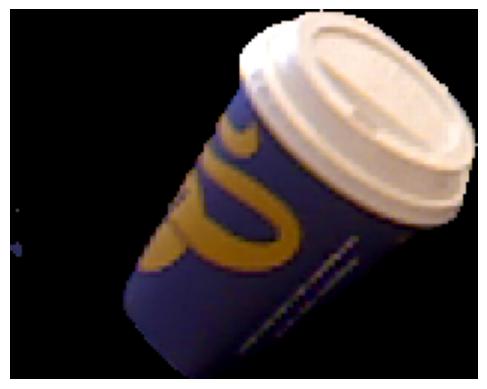

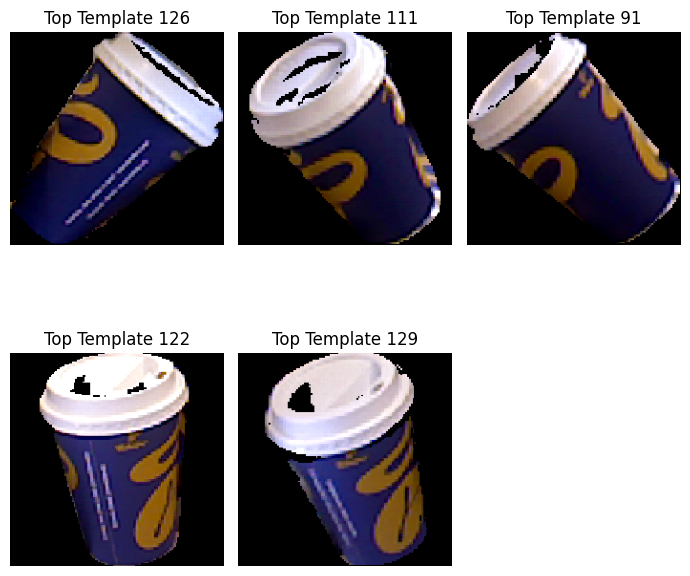

Top 5 scores: [0.878, 0.876, 0.862, 0.854, 0.854]
Average score: 0.865


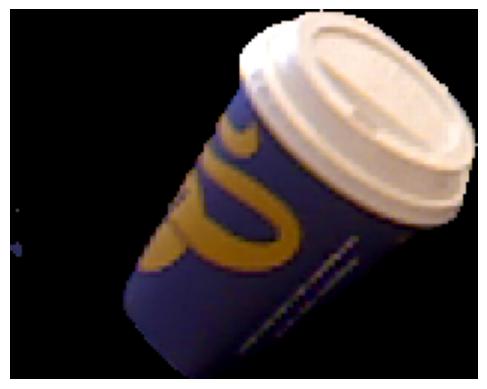

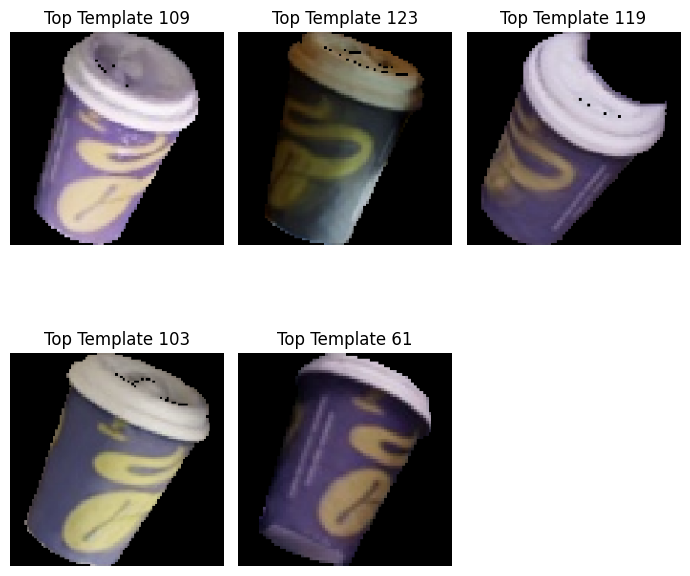

Top 5 scores: [0.852, 0.84, 0.823, 0.813, 0.783]
Average score: 0.822


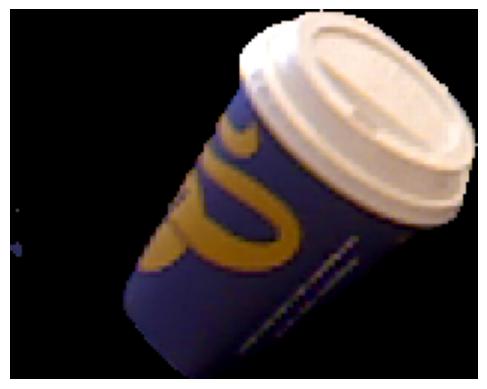

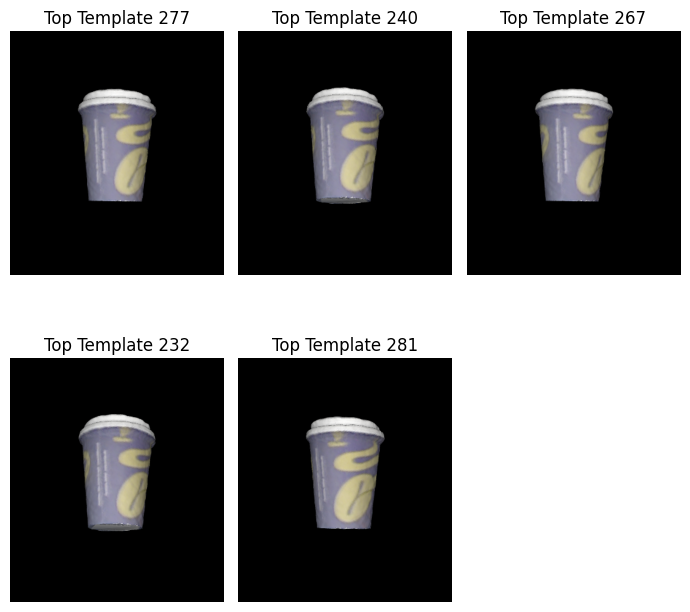

Top 5 scores: [0.818, 0.81, 0.809, 0.802, 0.798]
Average score: 0.807


In [21]:
from src.model.custom_cnos import cnos_crop_feature_extraction, calculate_similarity

# normal crop
crop_rgb = np.array(Image.open("cnos_analysis/crop_proposals/crop1.png").convert("RGB")) # (124, 157, 3)
normal_features = cnos_crop_feature_extraction(crop_rgb, dinov2_vitl14, device)
calculate_similarity(crop_rgb, normal_features, real_ref_features, real_templates)
calculate_similarity(crop_rgb, normal_features, syn_ref_features, syn_templates)
calculate_similarity(crop_rgb, normal_features, pyrender_ref_features, pyrender_templates)

## 3.2 Zoomed crop

In [22]:
from scipy.ndimage import zoom
def zoom_in(image, scale):
    return zoom(image, (scale, scale, 1))[image.shape[0]:,image.shape[1]:,:]

def zoom_out(image, scale):
    zoomed_out_image =  zoom(image, (1/scale, 1/scale, 1))
    # print(np.min(zoomed_out_image))
    background = np.zeros((image.shape[0], image.shape[1], image.shape[2]))
    background[image.shape[0]//2:zoomed_out_image.shape[0]+image.shape[0]//2, image.shape[0]//2:zoomed_out_image.shape[1]
        +image.shape[0]//2,:] = zoomed_out_image
    # print(np.min(background))
    # Clip values to be in the valid range [0, 255] and convert back to uint8
    background = background.astype("uint8")
    return background

crop_rgb = np.array(Image.open("cnos_analysis/crop_proposals/crop1.png").convert("RGB")) # (124, 157, 3)
zoom_scale = 3  # Zoom in by a factor of 2
crop_rgb_zoomed_in = zoom_in(crop_rgb, zoom_scale)
crop_rgb_zoomed_out = zoom_out(crop_rgb, scale=2)

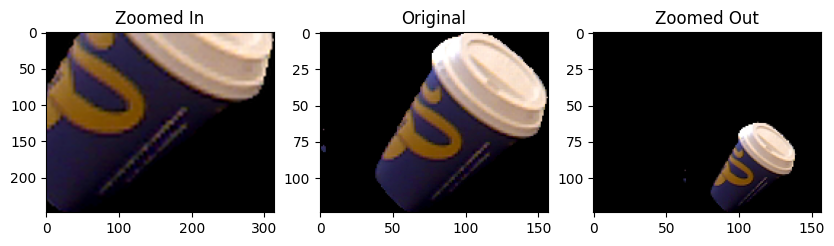

In [23]:
import matplotlib.pyplot as plt
# Display the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title(f"Zoomed In")
plt.imshow(crop_rgb_zoomed_in)

plt.subplot(1, 3, 2)
plt.title(f"Original")
plt.imshow(crop_rgb)

plt.subplot(1, 3, 3)
plt.title(f"Zoomed Out")
plt.imshow(crop_rgb_zoomed_out)

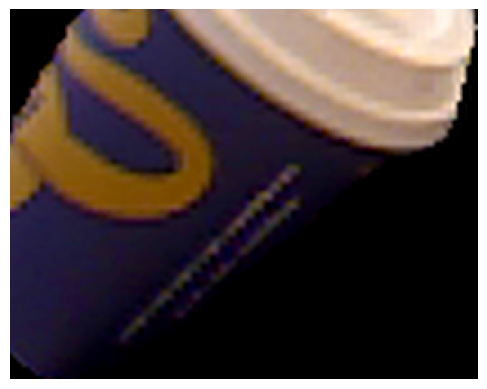

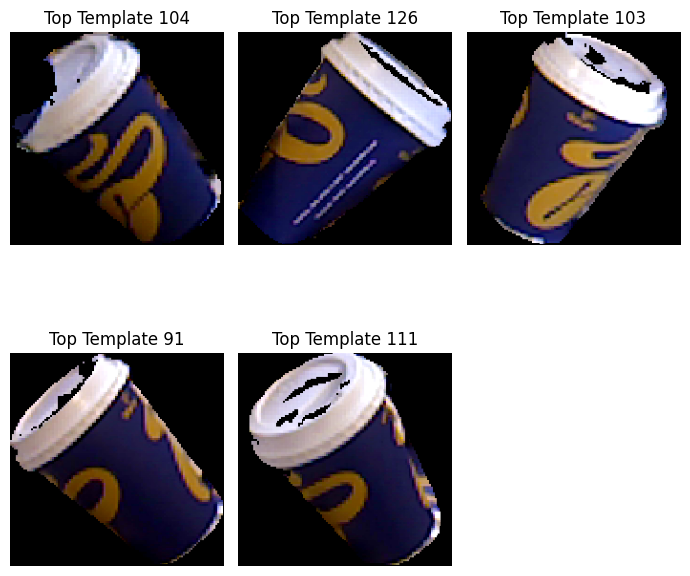

Top 5 scores: [0.836, 0.835, 0.811, 0.807, 0.805]
Average score: 0.819


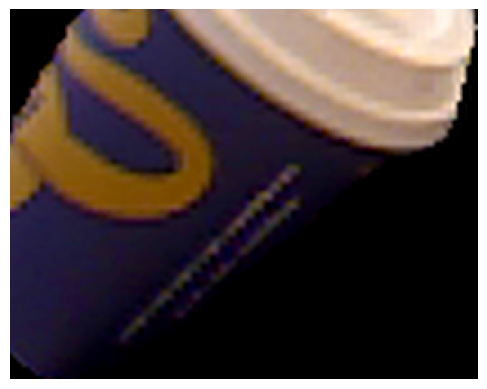

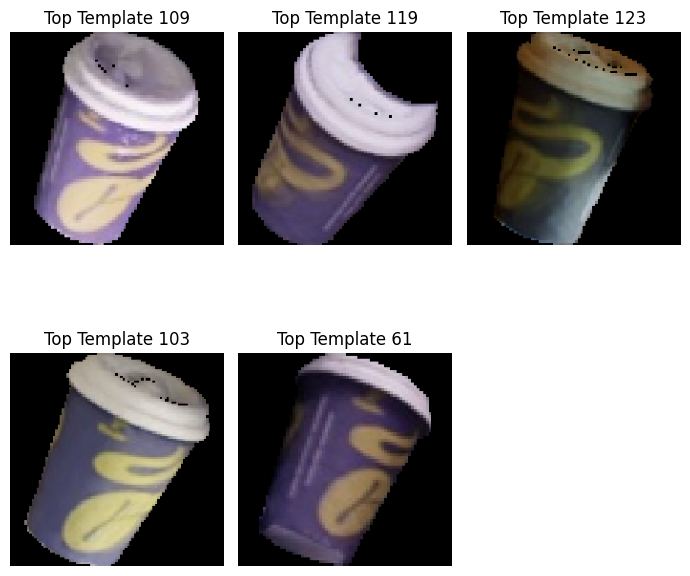

Top 5 scores: [0.784, 0.765, 0.764, 0.741, 0.711]
Average score: 0.753


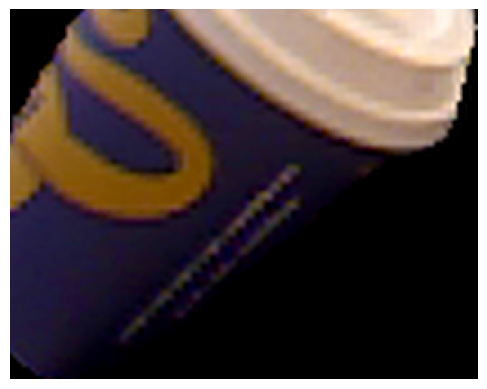

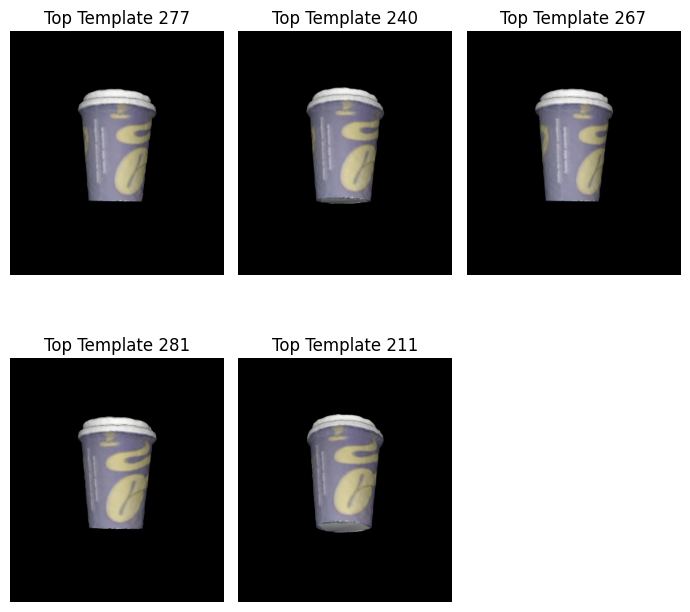

Top 5 scores: [0.76, 0.757, 0.755, 0.748, 0.743]
Average score: 0.753
Cosine similarity to the original crop tensor([[0.8915]], device='cuda:0')


In [24]:
from src.model.loss import PairwiseSimilarity, Similarity

metric = Similarity()
# Zoomed-in crop
zoom_in_features = cnos_crop_feature_extraction(crop_rgb_zoomed_in, dinov2_vitl14, device)
calculate_similarity(crop_rgb_zoomed_in, zoom_in_features, real_ref_features, real_templates)
calculate_similarity(crop_rgb_zoomed_in, zoom_in_features, syn_ref_features, syn_templates)
calculate_similarity(crop_rgb_zoomed_in, zoom_in_features, pyrender_ref_features, pyrender_templates)

# Calculate similarity between 2 features of nomrmal crop and rotated_45_crop
zoom_in_scores = metric(normal_features[:, None, :], zoom_in_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_prosals*num_templates instead
print("Cosine similarity to the original crop", zoom_in_scores)

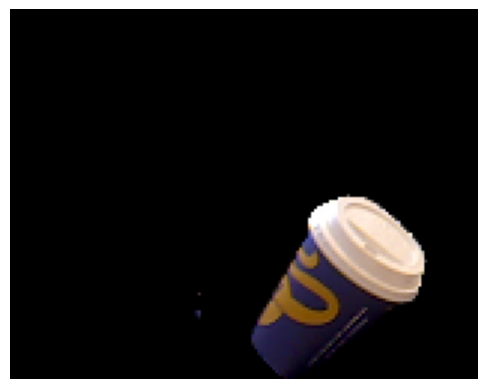

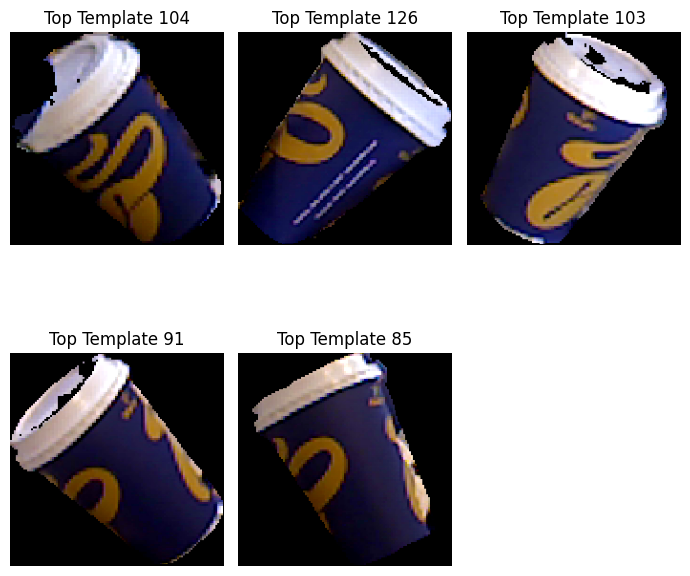

Top 5 scores: [0.792, 0.752, 0.746, 0.745, 0.742]
Average score: 0.755


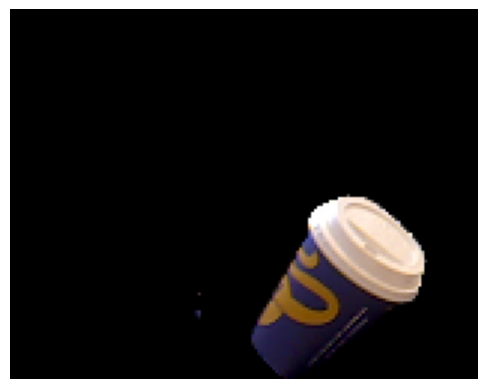

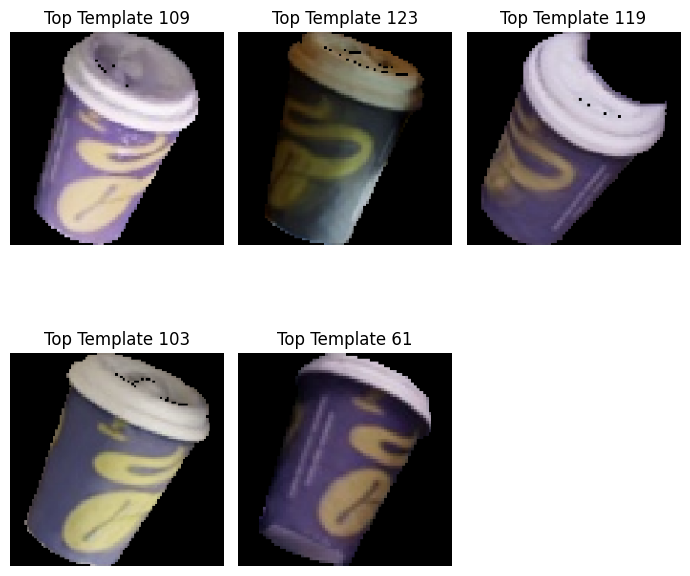

Top 5 scores: [0.696, 0.693, 0.691, 0.658, 0.651]
Average score: 0.678


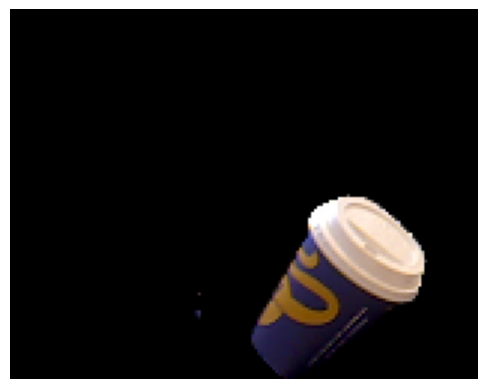

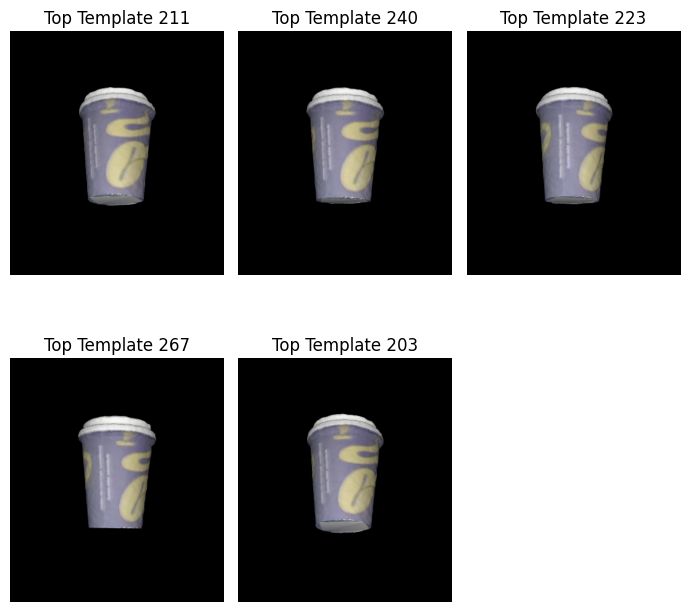

Top 5 scores: [0.71, 0.708, 0.707, 0.7, 0.699]
Average score: 0.705
Cosine similarity to the original crop tensor([[0.8179]], device='cuda:0')


In [25]:
# Zoomed-out crop
zoom_out_features = cnos_crop_feature_extraction(crop_rgb_zoomed_out, dinov2_vitl14, device)
calculate_similarity(crop_rgb_zoomed_out, zoom_out_features, real_ref_features, real_templates)
calculate_similarity(crop_rgb_zoomed_out, zoom_out_features, syn_ref_features, syn_templates)
calculate_similarity(crop_rgb_zoomed_out, zoom_out_features, pyrender_ref_features, pyrender_templates)
# Calculate similarity between 2 features of normal crop and rotated_45_crop
zoom_out_scores = metric(normal_features[:, None, :], zoom_out_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_proposals*num_templates instead
print("Cosine similarity to the original crop", zoom_out_scores)

## 3.3 In-plane rotated crop

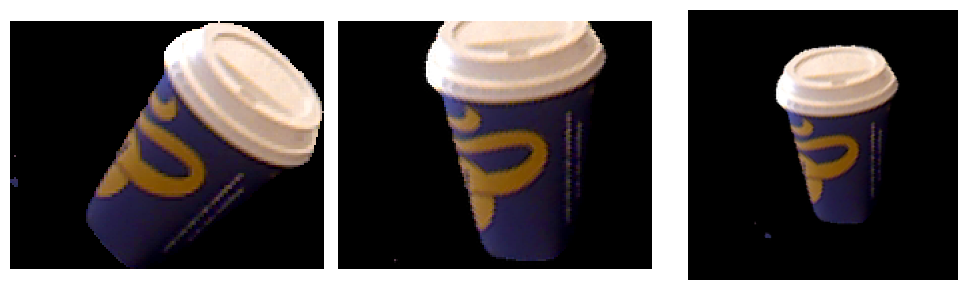

In [26]:
from scipy import ndimage, datasets
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 3))
ax1, ax2, ax3 = fig.subplots(1, 3)
img = crop_rgb
img_45 = ndimage.rotate(img, 45, reshape=False)
full_img_45 = ndimage.rotate(img, 45, reshape=True)
ax1.imshow(img, cmap='gray')
ax1.set_axis_off()
ax2.imshow(img_45, cmap='gray')
ax2.set_axis_off()
ax3.imshow(full_img_45, cmap='gray')
ax3.set_axis_off()
fig.set_layout_engine('tight')
plt.show()

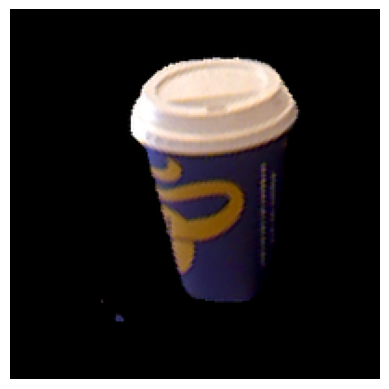

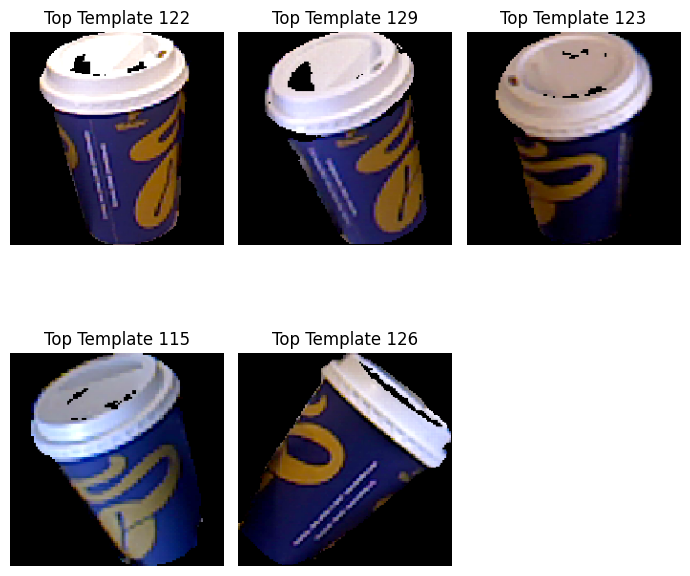

Top 5 scores: [0.89, 0.873, 0.87, 0.866, 0.866]
Average score: 0.873


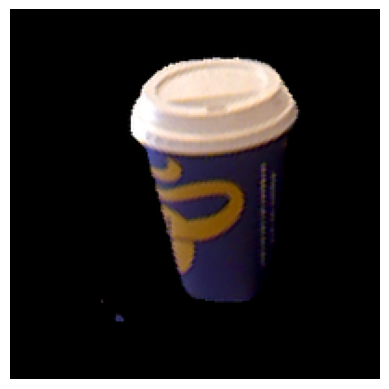

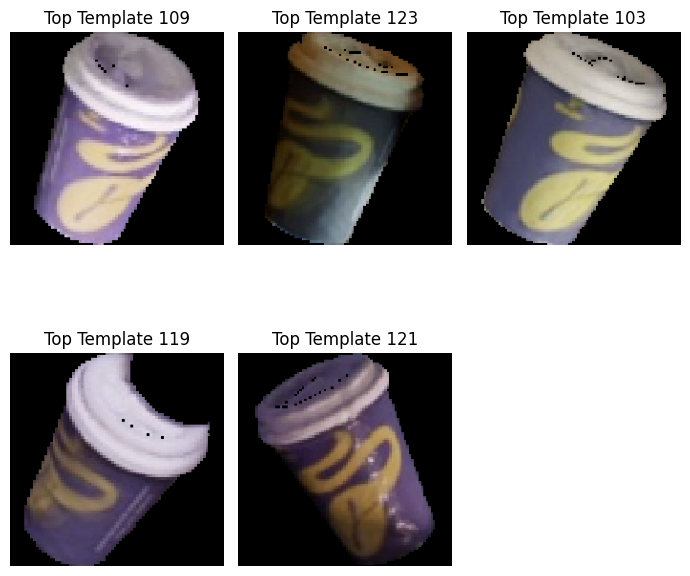

Top 5 scores: [0.851, 0.812, 0.792, 0.775, 0.77]
Average score: 0.8


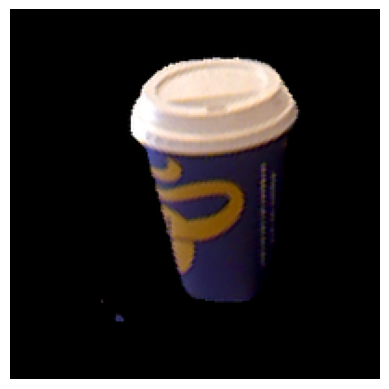

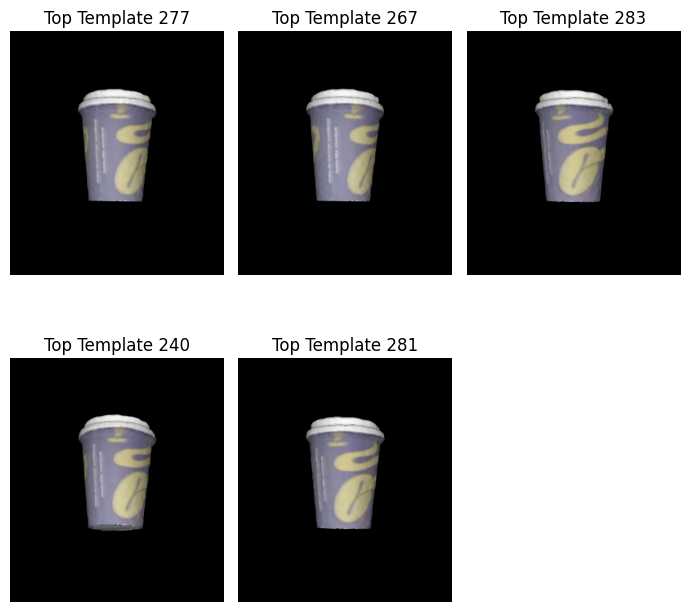

Top 5 scores: [0.829, 0.821, 0.816, 0.813, 0.812]
Average score: 0.818


tensor([[0.9000]], device='cuda:0')

In [27]:
# Rotate 45 
rotated_45_features = cnos_crop_feature_extraction(img_45, dinov2_vitl14, device)
calculate_similarity(full_img_45, rotated_45_features, real_ref_features, real_templates)
calculate_similarity(full_img_45, rotated_45_features, syn_ref_features, syn_templates)
calculate_similarity(full_img_45, rotated_45_features, pyrender_ref_features, pyrender_templates)
# Calculate similarity between 2 features of nomrmal crop and rotated_45_crop
rotated_45_scores = metric(normal_features[:, None, :], rotated_45_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_prosals*num_templates instead
rotated_45_scores

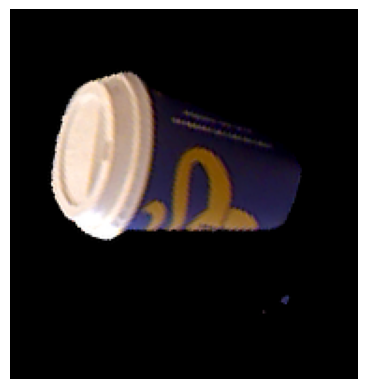

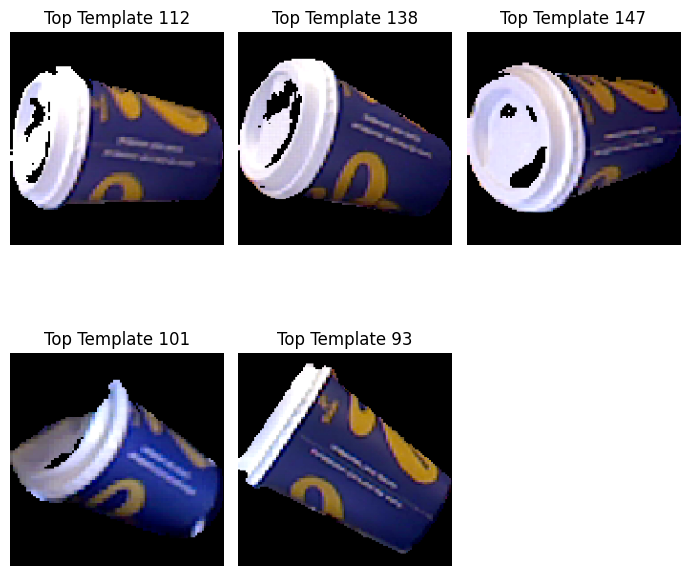

Top 5 scores: [0.836, 0.827, 0.792, 0.779, 0.772]
Average score: 0.801


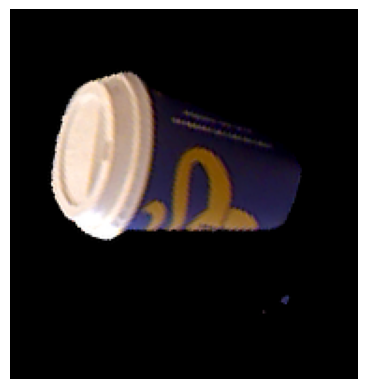

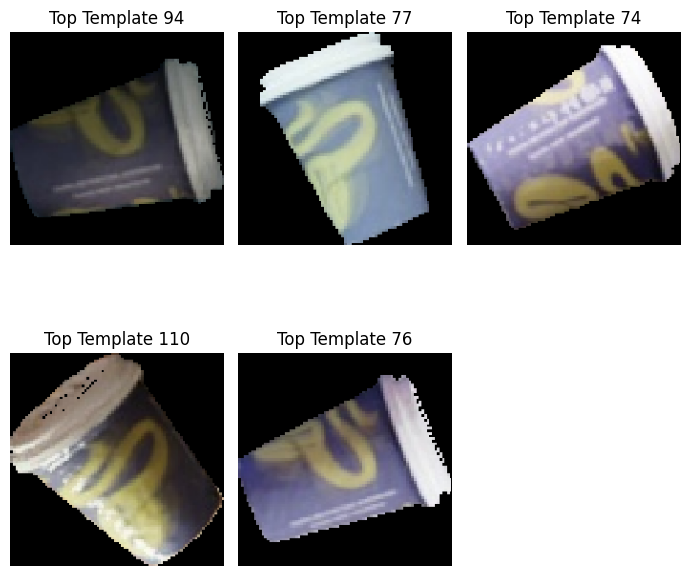

Top 5 scores: [0.746, 0.743, 0.742, 0.741, 0.737]
Average score: 0.742


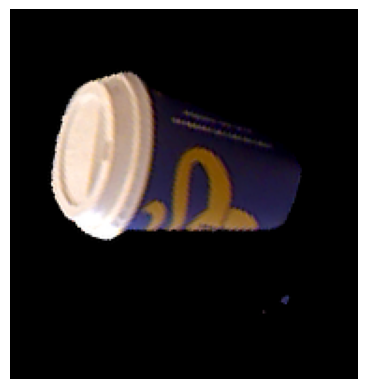

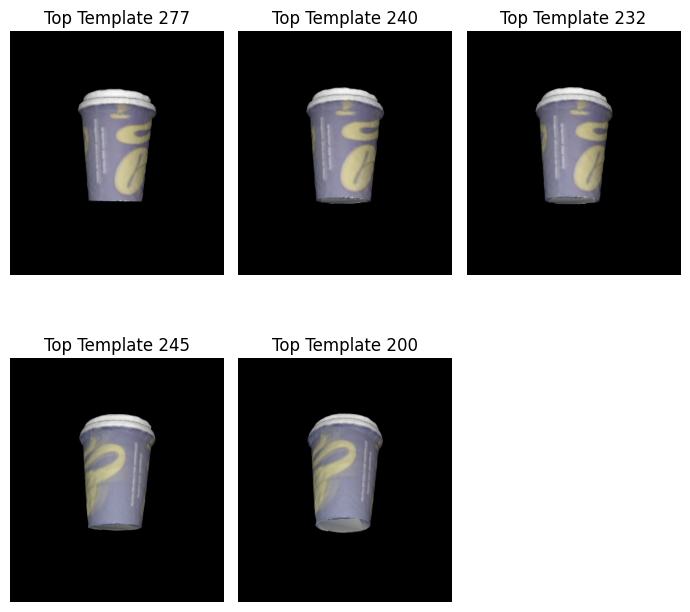

Top 5 scores: [0.769, 0.766, 0.763, 0.762, 0.762]
Average score: 0.764


tensor([[0.7664]], device='cuda:0')

In [28]:
# Rotate 120
img_120 = ndimage.rotate(img, 120, reshape=False)
full_img_120 = ndimage.rotate(img, 120, reshape=True)
# Rotate 120
rotated_120_features = cnos_crop_feature_extraction(full_img_120, dinov2_vitl14, device)
calculate_similarity(full_img_120, rotated_120_features, real_ref_features, real_templates)
calculate_similarity(full_img_120, rotated_120_features, syn_ref_features, syn_templates)
calculate_similarity(full_img_120, rotated_120_features, pyrender_ref_features, pyrender_templates)
# Calculate similarity between 2 features of normal crop and rotated_120_crop
rotated_120_scores = metric(normal_features[:, None, :], rotated_120_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_proposals*num_templates instead
rotated_120_scores


## 3.4 Occluded crop

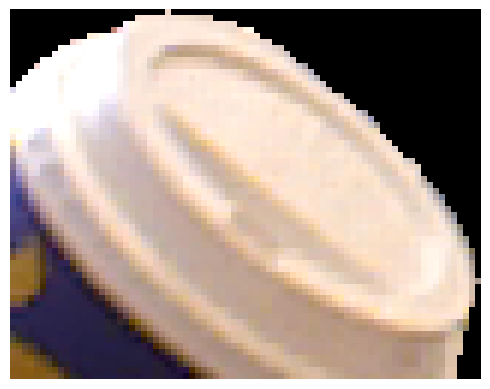

In [29]:
# occluded_crop = crop_rgb[124//2:,:157//2,:]
occluded_crop = crop_rgb[:124//2,157//2:,:]
import matplotlib.pyplot as plt
plt.imshow(occluded_crop)
plt.axis("off")
plt.show()

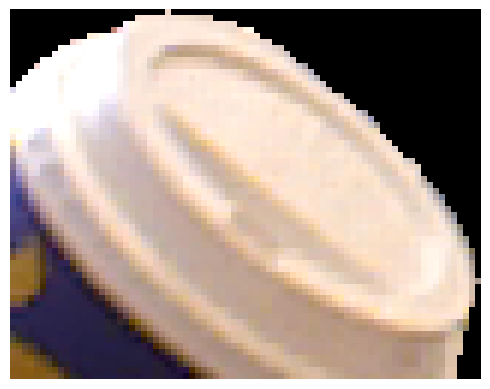

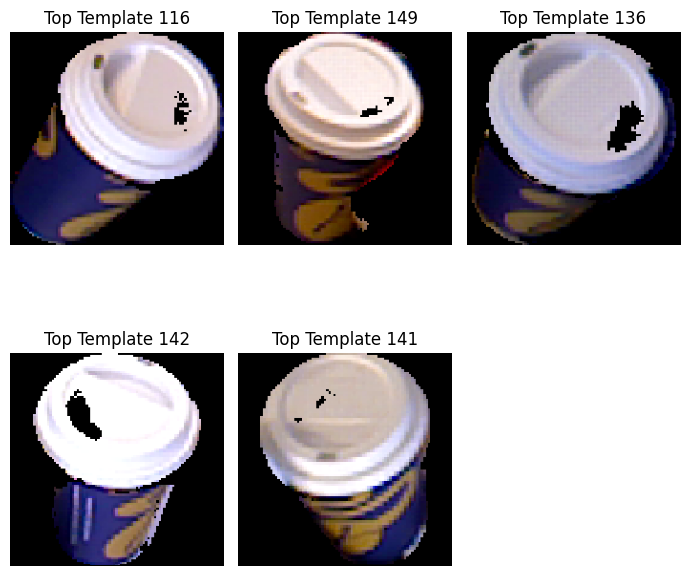

Top 5 scores: [0.757, 0.746, 0.739, 0.737, 0.735]
Average score: 0.743


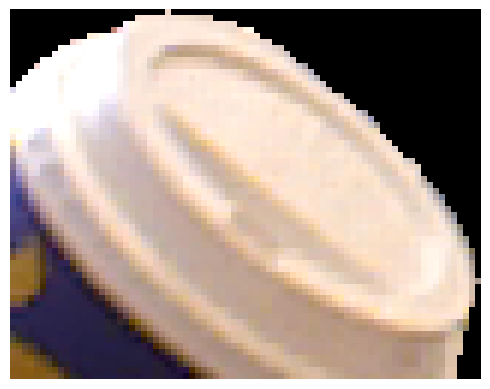

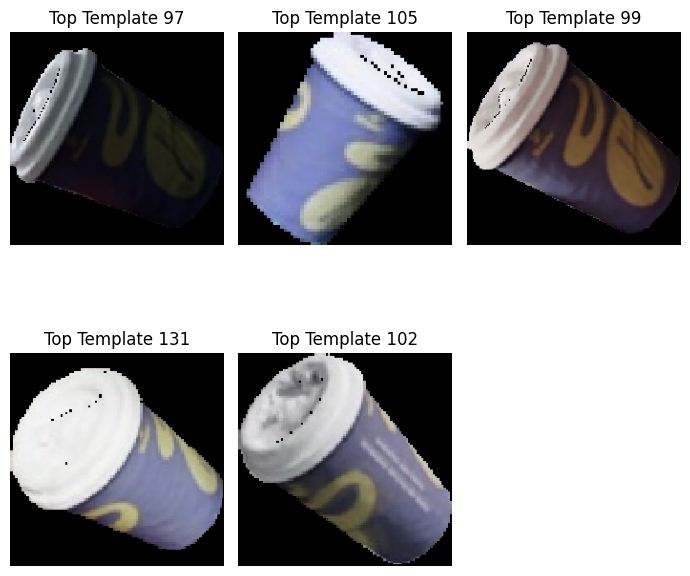

Top 5 scores: [0.653, 0.644, 0.636, 0.629, 0.621]
Average score: 0.637


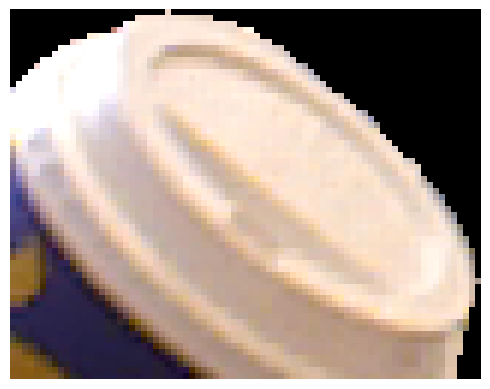

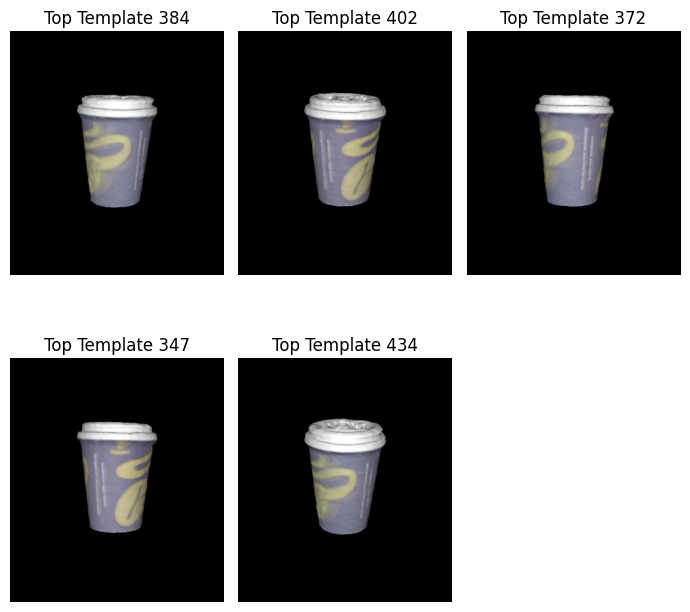

Top 5 scores: [0.627, 0.625, 0.622, 0.615, 0.614]
Average score: 0.62


tensor([[0.6306]], device='cuda:0')

In [30]:
occluded_features = cnos_crop_feature_extraction(occluded_crop, dinov2_vitl14, device)
# Real templates
calculate_similarity(occluded_crop, occluded_features, real_ref_features, real_templates)
calculate_similarity(occluded_crop, occluded_features, syn_ref_features, syn_templates)
calculate_similarity(occluded_crop, occluded_features, pyrender_ref_features, pyrender_templates)
# Calculate similarity between 2 features of nomrmal crop and rotated_45_crop
occluded_scores = metric(normal_features[:, None, :], occluded_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_prosals*num_templates instead
occluded_scores

In [31]:
900,1024

(900, 1024)

## 3.5 Small crop

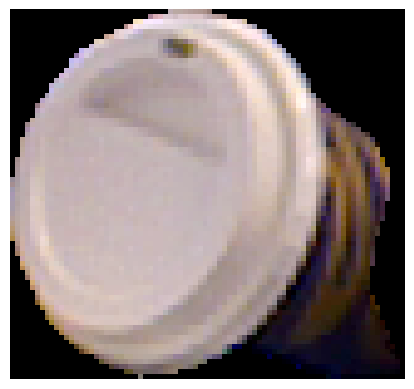

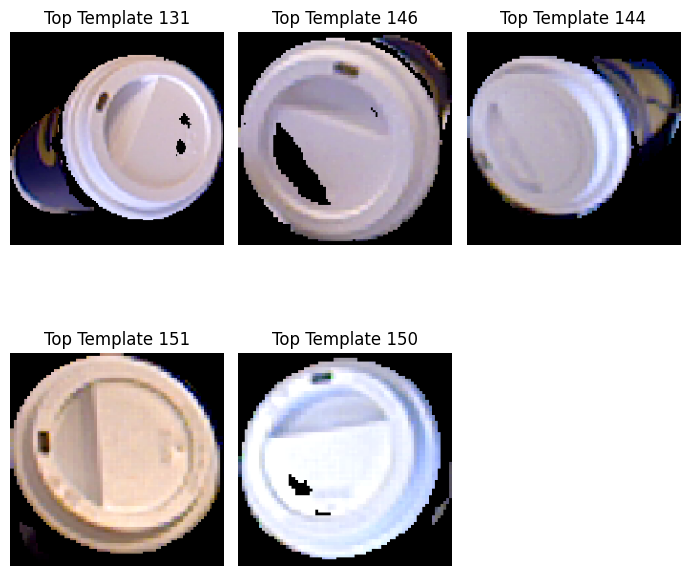

Top 5 scores: [0.728, 0.714, 0.681, 0.678, 0.671]
Average score: 0.694


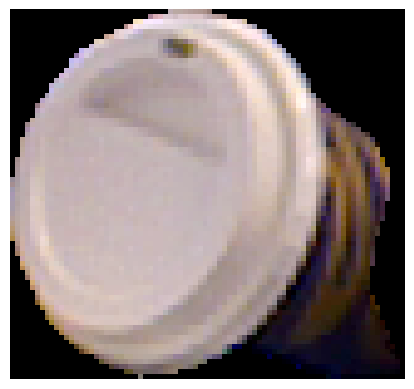

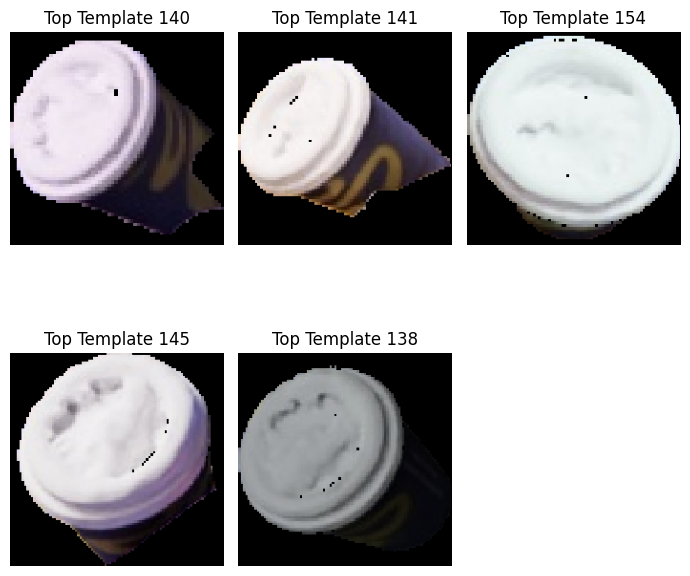

Top 5 scores: [0.546, 0.502, 0.474, 0.462, 0.43]
Average score: 0.483


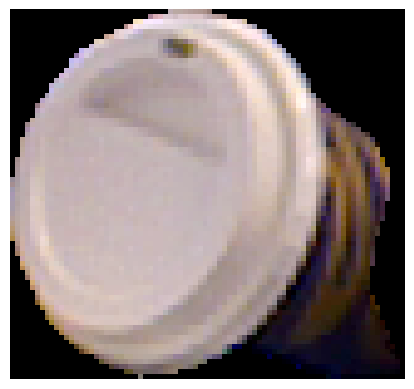

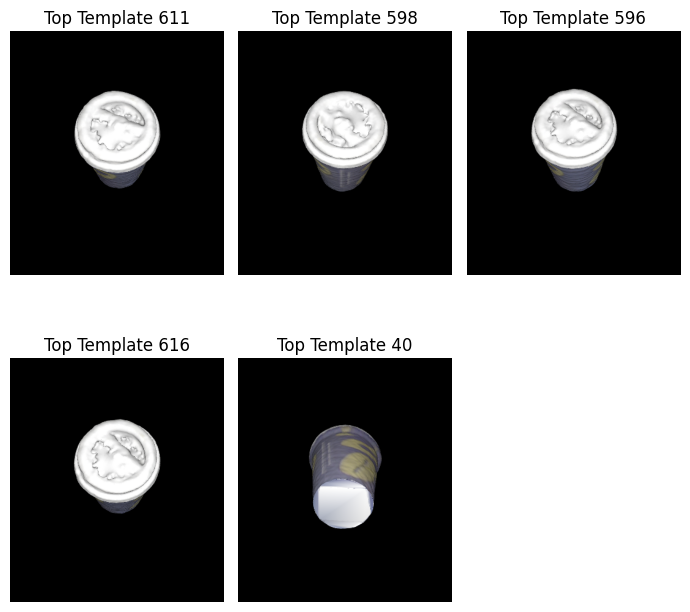

Top 5 scores: [0.382, 0.344, 0.333, 0.324, 0.322]
Average score: 0.341


In [32]:
# Small crop
small_crop_rgb = np.array(Image.open("cnos_analysis/crop_proposals/crop2.png").convert("RGB")) # (124, 157, 3)
# normal crop
small_features = cnos_crop_feature_extraction(small_crop_rgb, dinov2_vitl14, device)
calculate_similarity(small_crop_rgb, small_features, real_ref_features, real_templates)
calculate_similarity(small_crop_rgb, small_features, syn_ref_features, syn_templates)
calculate_similarity(small_crop_rgb, small_features, pyrender_ref_features, pyrender_templates)

In [33]:
1, 1024
162, 1024

(162, 1024)

In [34]:
30,30,1024

(30, 30, 1024)

## 3.6 Background Crop

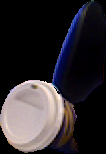

In [35]:
crop1["crop"]

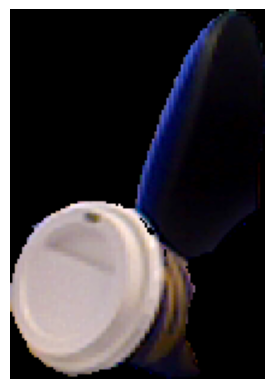

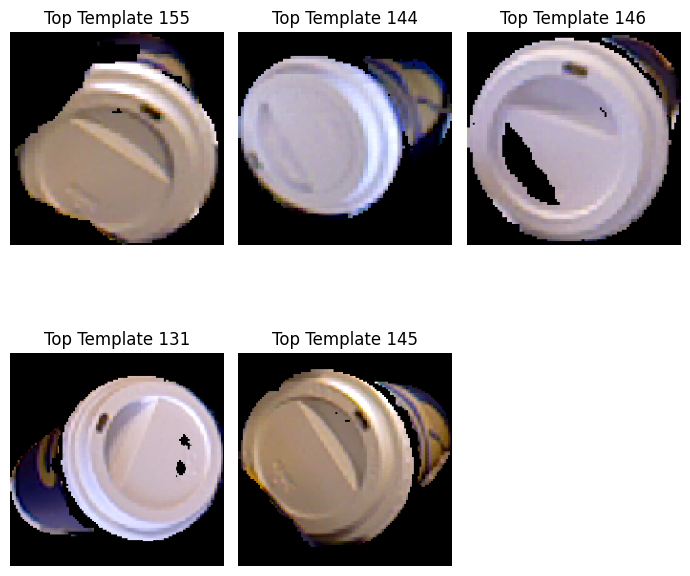

Top 5 scores: [0.543, 0.532, 0.502, 0.491, 0.483]
Average score: 0.51


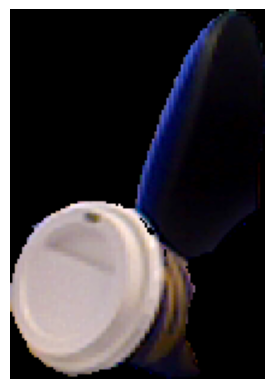

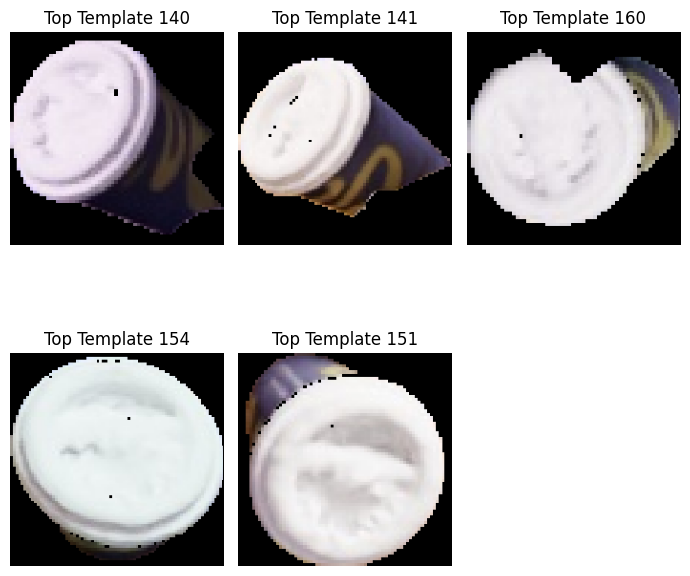

Top 5 scores: [0.416, 0.414, 0.414, 0.383, 0.374]
Average score: 0.4


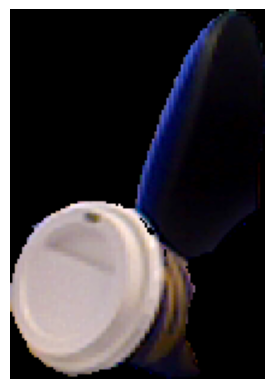

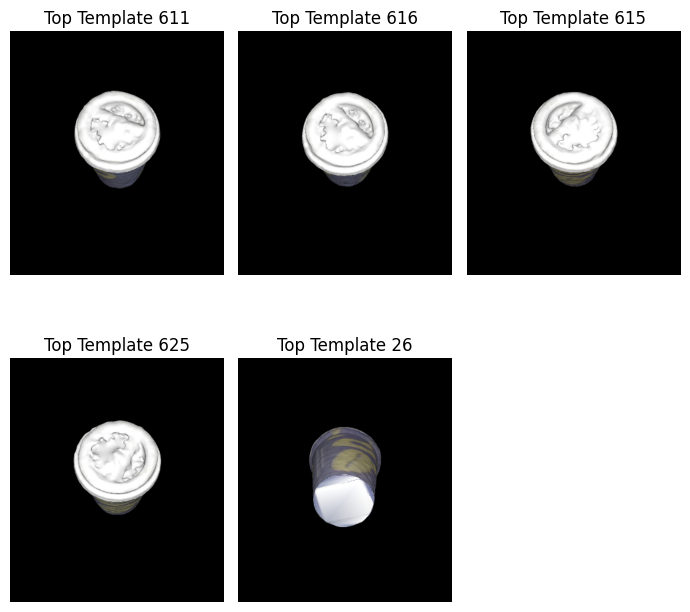

Top 5 scores: [0.291, 0.287, 0.287, 0.279, 0.274]
Average score: 0.284


In [36]:
background_crop = np.array(crop1["crop"]) # (124, 157, 3)
background_features = cnos_crop_feature_extraction(background_crop, dinov2_vitl14, device)
calculate_similarity(background_crop, background_features, real_ref_features, real_templates)
calculate_similarity(background_crop, background_features, syn_ref_features, syn_templates)
calculate_similarity(background_crop, background_features, pyrender_ref_features, pyrender_templates)

In [37]:
900*1024


921600

# 4. Final Results

In [38]:
proposals = [np.array(masked_image) for i, masked_image in enumerate(masked_images)]
proposals_features = torch.cat([cnos_crop_feature_extraction(proposal, dinov2_vitl14, device) for proposal in proposals], dim = 0)

In [39]:
proposals_features.shape

torch.Size([151, 1024])

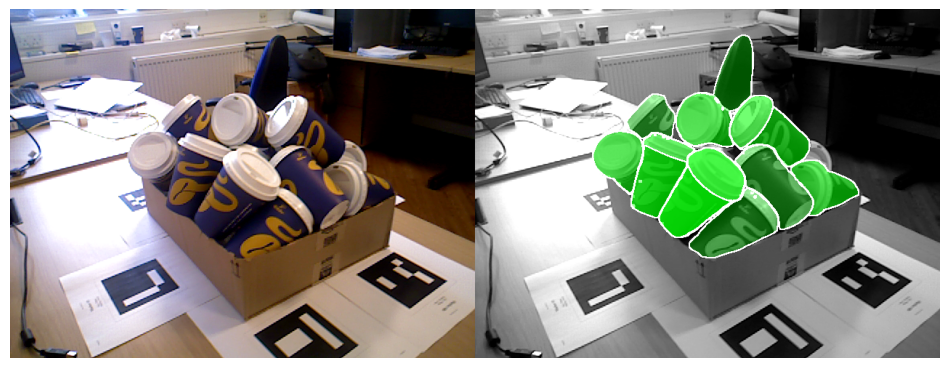

In [40]:
from src.model.custom_cnos import modified_run_inference

rgb_path = "cnos_analysis/crop_proposals/000001.png"
template_dir = "foundpose_analysis/icbin/templates/test_images_templates/obj_000001_original"
modified_run_inference(template_dir, rgb_path, detections, real_ref_features, proposals_features)# , num_max_dets=15)

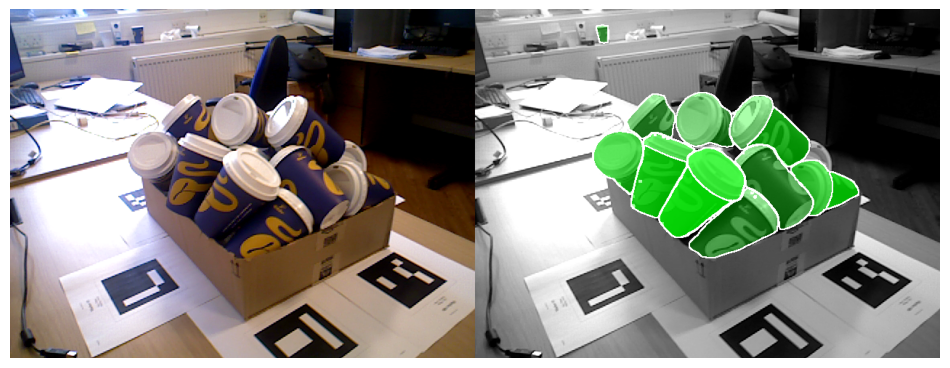

In [41]:
syn_template_dir = "foundpose_analysis/icbin/templates/train_pbr_images_templates/obj_000001_original"
modified_run_inference(syn_template_dir, rgb_path, detections, syn_ref_features, proposals_features)

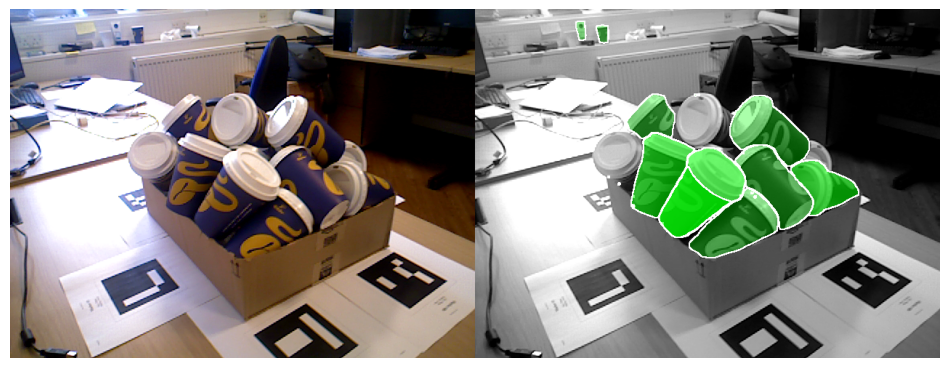

In [42]:
pyrender_template_dir = "datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_000001"
modified_run_inference(pyrender_template_dir, rgb_path, detections, pyrender_ref_features, proposals_features)